In [ ]:
# SPDX-FileCopyrightText: Copyright (c) 2025 NVIDIA CORPORATION & AFFILIATES. All rights reserved.
# SPDX-License-Identifier: Apache-2.0

import matplotlib.pyplot as plt

from aiconfigurator.sdk import common
from aiconfigurator.sdk.perf_database import get_database

system = "gb200"
database = get_database(system=system, backend="trtllm", version="1.0.0rc6")

from aiconfigurator.sdk.common import SOLMode

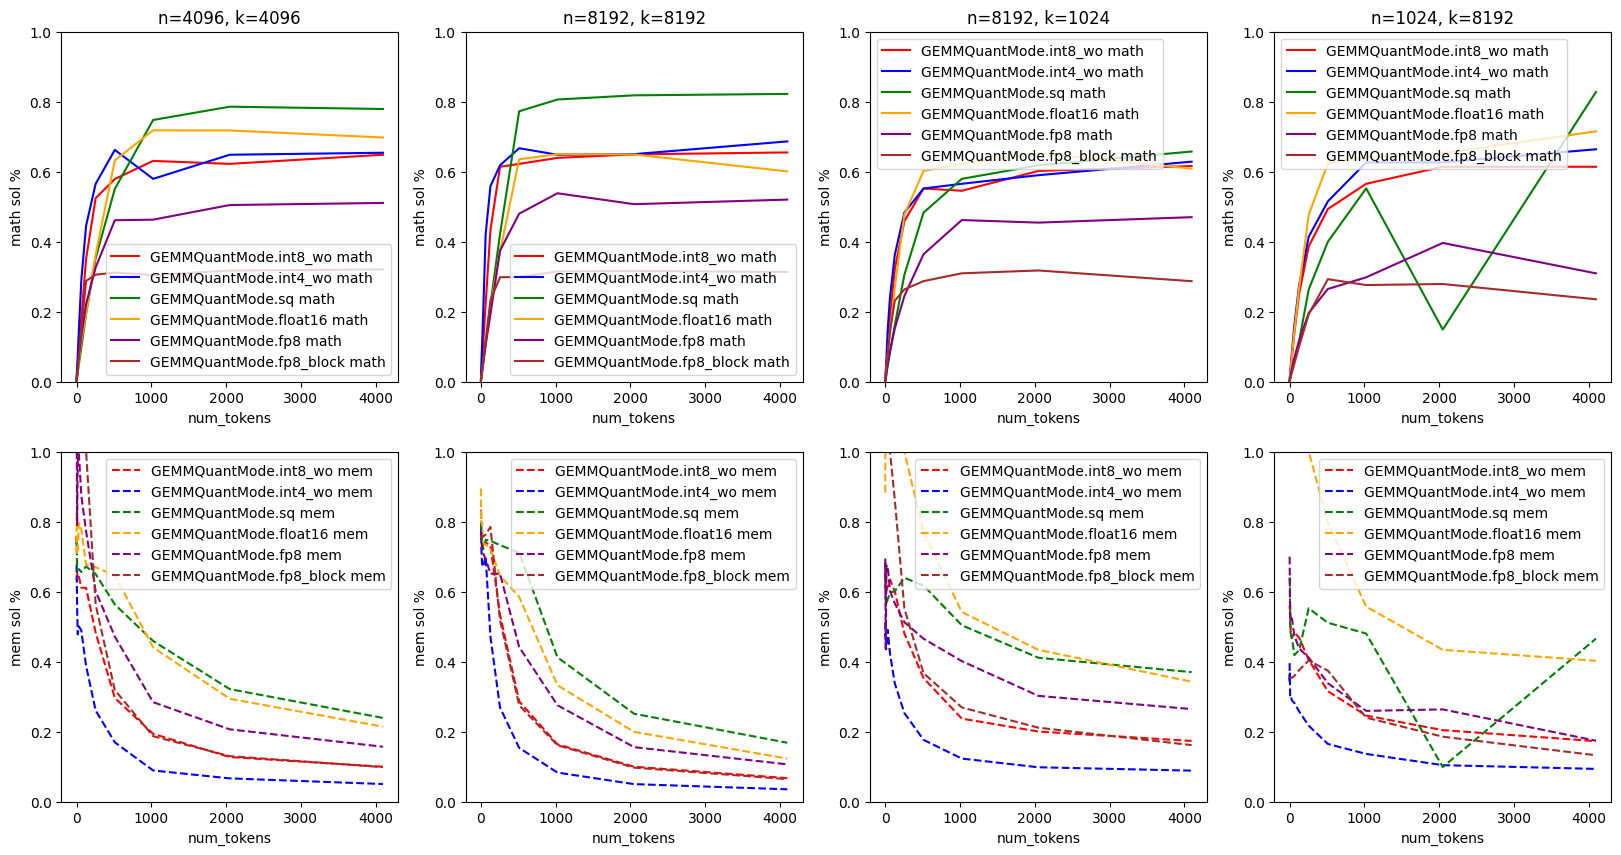

In [ ]:
def visualize_gemm(database):
    # gemm
    n_k = [[4096, 4096], [8192, 8192], [8192, 1024], [1024, 8192]]
    m_list = [1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048, 4096]

    color_list = [
        "red",
        "blue",
        "green",
        "orange",
        "purple",
        "brown",
        "pink",
        "gray",
        "olive",
        "cyan",
    ]
    fig, ax = plt.subplots(2, len(n_k), figsize=(5 * len(n_k), 5 * 2))
    for i, (n, k) in enumerate(n_k):
        for color_id, quant_mode in enumerate(database._gemm_data.keys()):
            sol_math_list = []
            sol_mem_list = []
            for m in m_list:
                sol_time, sol_math, sol_mem = database.query_gemm(
                    m=m, n=n, k=k, quant_mode=quant_mode, sol_mode=SOLMode.SOL_FULL
                )
                db_time = database.query_gemm(
                    m=m, n=n, k=k, quant_mode=quant_mode, sol_mode=SOLMode.NON_SOL
                )
                percentage_of_math = sol_math / db_time
                percentage_of_mem = sol_mem / db_time
                sol_math_list.append(percentage_of_math)
                sol_mem_list.append(percentage_of_mem)
            ax[0, i].plot(
                m_list, sol_math_list, color=color_list[color_id], label=f"{quant_mode} math"
            )
            ax[1, i].plot(
                m_list,
                sol_mem_list,
                color=color_list[color_id],
                linestyle="--",
                label=f"{quant_mode} mem",
            )
        ax[0, i].set_title(f"n={n}, k={k}")
        ax[0, i].set_xlabel("num_tokens")
        ax[0, i].set_ylabel("math sol %")
        ax[0, i].set_ylim(0, 1)
        ax[0, i].legend()
        ax[1, i].set_xlabel("num_tokens")
        ax[1, i].set_ylabel("mem sol %")
        ax[1, i].set_ylim(0, 1)
        ax[1, i].legend()
    plt.show()


visualize_gemm(database)

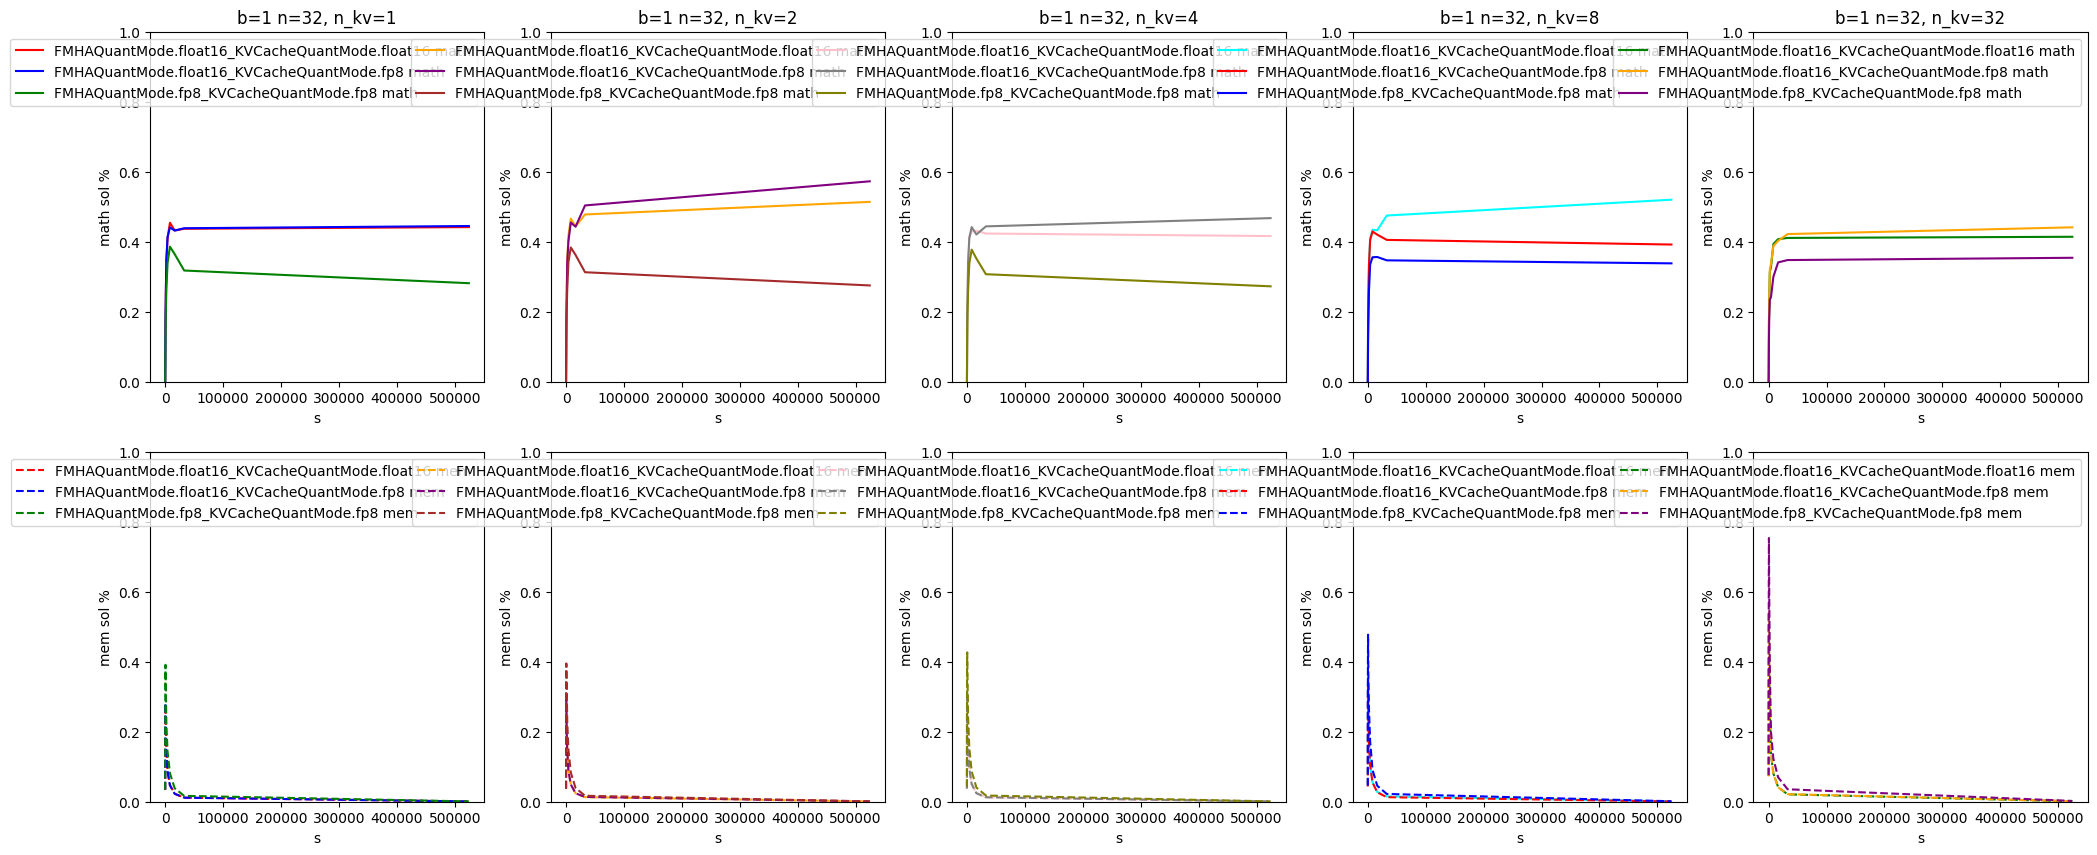

In [3]:
def visualize_context_attention(database):
    b = 1
    n = 32
    n_kv_list = [1, 2, 4, 8, 32]
    s_list = [16, 32, 64, 128, 256, 512, 1024, 2048, 4096, 8192, 16384, 32768, 524288]

    color_list = [
        "red",
        "blue",
        "green",
        "orange",
        "purple",
        "brown",
        "pink",
        "gray",
        "olive",
        "cyan",
    ]
    fig, ax = plt.subplots(2, len(n_kv_list), figsize=(5 * len(n_kv_list), 5 * 2))
    color_id = 0
    for i, n_kv in enumerate(n_kv_list):
        for quant_mode in database._context_attention_data.keys():
            for kvcache_quant_mode in database._context_attention_data[quant_mode].keys():
                sol_math_list = []
                sol_mem_list = []
                for s in s_list:
                    sol_time, sol_math, sol_mem = database.query_context_attention(
                        b=b,
                        s=s,
                        n=n,
                        n_kv=n_kv,
                        kvcache_quant_mode=kvcache_quant_mode,
                        fmha_quant_mode=quant_mode,
                        sol_mode=SOLMode.SOL_FULL,
                    )
                    db_time = database.query_context_attention(
                        b=b,
                        s=s,
                        n=n,
                        n_kv=n_kv,
                        kvcache_quant_mode=kvcache_quant_mode,
                        fmha_quant_mode=quant_mode,
                        sol_mode=SOLMode.NON_SOL,
                    )
                    percentage_of_math = sol_math / db_time
                    percentage_of_mem = sol_mem / db_time
                    sol_math_list.append(percentage_of_math)
                    sol_mem_list.append(percentage_of_mem)
                ax[0, i].plot(
                    s_list,
                    sol_math_list,
                    color=color_list[color_id % len(color_list)],
                    label=f"{quant_mode}_{kvcache_quant_mode} math",
                )
                ax[1, i].plot(
                    s_list,
                    sol_mem_list,
                    color=color_list[color_id % len(color_list)],
                    linestyle="--",
                    label=f"{quant_mode}_{kvcache_quant_mode} mem",
                )
                color_id += 1
        ax[0, i].set_title(f"b={b} n={n}, n_kv={n_kv}")
        ax[0, i].set_xlabel("s")
        ax[0, i].set_ylabel("math sol %")
        ax[0, i].set_ylim(0, 1)
        ax[0, i].legend()
        ax[1, i].set_xlabel("s")
        ax[1, i].set_ylabel("mem sol %")
        ax[1, i].set_ylim(0, 1)
        ax[1, i].legend()
    plt.show()


visualize_context_attention(database)

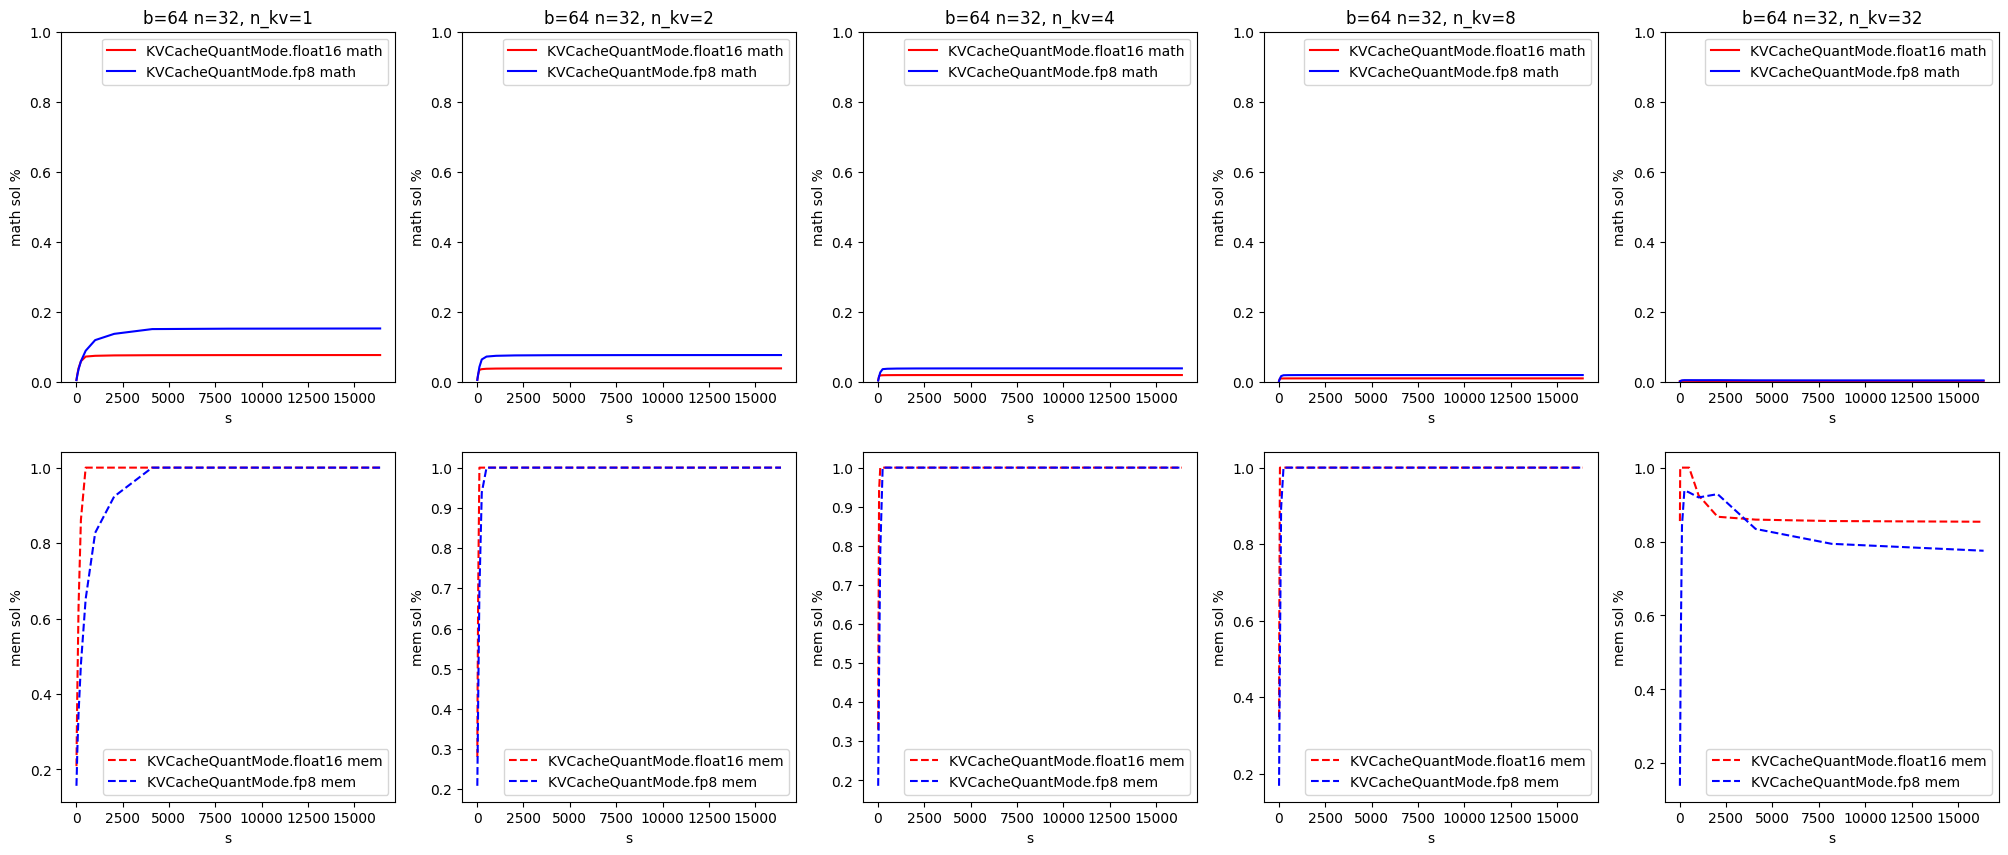

In [4]:
def visualize_generation_attention(database):
    b = 64
    n = 32
    n_kv_list = [1, 2, 4, 8, n]
    s_list = [16, 32, 64, 128, 256, 512, 1024, 2048, 4096, 8192, 16384]

    color_list = [
        "red",
        "blue",
        "green",
        "orange",
        "purple",
        "brown",
        "pink",
        "gray",
        "olive",
        "cyan",
    ]
    fig, ax = plt.subplots(2, len(n_kv_list), figsize=(5 * len(n_kv_list), 5 * 2))
    for i, n_kv in enumerate(n_kv_list):
        for color_id, kvcache_quant_mode in enumerate(database._generation_attention_data.keys()):
            sol_math_list = []
            sol_mem_list = []
            for s in s_list:
                sol_time, sol_math, sol_mem = database.query_generation_attention(
                    b=b,
                    s=s,
                    n=n,
                    n_kv=n_kv,
                    kvcache_quant_mode=kvcache_quant_mode,
                    sol_mode=SOLMode.SOL_FULL,
                )
                db_time = database.query_generation_attention(
                    b=b,
                    s=s,
                    n=n,
                    n_kv=n_kv,
                    kvcache_quant_mode=kvcache_quant_mode,
                    sol_mode=SOLMode.NON_SOL,
                )
                percentage_of_math = sol_math / db_time
                percentage_of_mem = sol_mem / db_time
                sol_math_list.append(percentage_of_math)
                sol_mem_list.append(percentage_of_mem)
            ax[0, i].plot(
                s_list,
                sol_math_list,
                color=color_list[color_id],
                label=f"{kvcache_quant_mode} math",
            )
            ax[1, i].plot(
                s_list,
                sol_mem_list,
                color=color_list[color_id],
                linestyle="--",
                label=f"{kvcache_quant_mode} mem",
            )
        ax[0, i].set_title(f"b={b} n={n}, n_kv={n_kv}")
        ax[0, i].set_xlabel("s")
        ax[0, i].set_ylabel("math sol %")
        ax[0, i].set_ylim(0, 1)
        ax[0, i].legend()
        ax[1, i].set_xlabel("s")
        ax[1, i].set_ylabel("mem sol %")
        # ax[1,i].set_ylim(0,1)
        ax[1, i].legend()
    plt.show()


visualize_generation_attention(database)
# visualize_generation_attention(database_fixed)

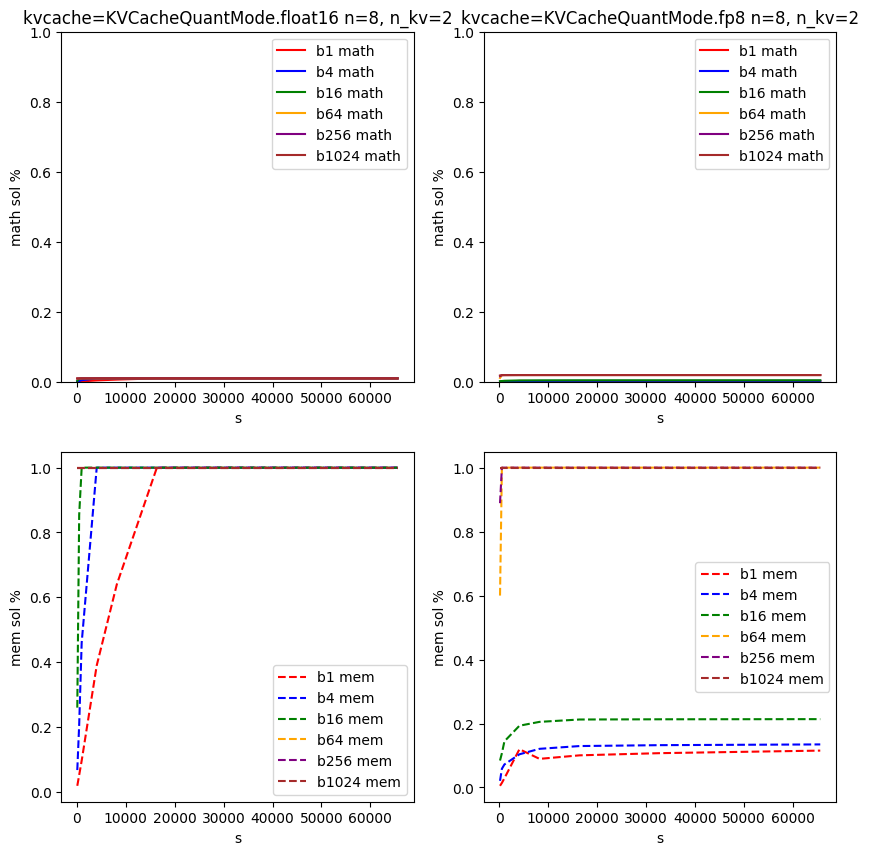

In [5]:
def visualize_generation_attention_b(database):
    b_list = [1, 4, 16, 64, 256, 1024]
    n = 8
    n_kv = 2
    s_list = [128, 512, 1024, 4096, 8192, 16384, 32768, 65535]

    color_list = [
        "red",
        "blue",
        "green",
        "orange",
        "purple",
        "brown",
        "pink",
        "gray",
        "olive",
        "cyan",
    ]
    fig, ax = plt.subplots(
        2,
        len(database._generation_attention_data.keys()),
        figsize=(5 * len(database._generation_attention_data.keys()), 5 * 2),
    )
    for i, kvcache_quant_mode in enumerate(database._generation_attention_data.keys()):
        for color_id, b in enumerate(b_list):
            sol_math_list = []
            sol_mem_list = []
            for s in s_list:
                sol_time, sol_math, sol_mem = database.query_generation_attention(
                    b=b,
                    s=s,
                    n=n,
                    n_kv=n_kv,
                    kvcache_quant_mode=kvcache_quant_mode,
                    sol_mode=SOLMode.SOL_FULL,
                )
                db_time = database.query_generation_attention(
                    b=b,
                    s=s,
                    n=n,
                    n_kv=n_kv,
                    kvcache_quant_mode=kvcache_quant_mode,
                    sol_mode=SOLMode.NON_SOL,
                )
                percentage_of_math = sol_math / db_time
                percentage_of_mem = sol_mem / db_time
                sol_math_list.append(percentage_of_math)
                sol_mem_list.append(percentage_of_mem)
            ax[0, i].plot(s_list, sol_math_list, color=color_list[color_id], label=f"b{b} math")
            ax[1, i].plot(
                s_list, sol_mem_list, color=color_list[color_id], linestyle="--", label=f"b{b} mem"
            )
        ax[0, i].set_title(f"kvcache={kvcache_quant_mode} n={n}, n_kv={n_kv}")
        ax[0, i].set_xlabel("s")
        ax[0, i].set_ylabel("math sol %")
        ax[0, i].set_ylim(0, 1)
        ax[0, i].legend()
        ax[1, i].set_xlabel("s")
        ax[1, i].set_ylabel("mem sol %")
        # ax[1,i].set_ylim(0,1)
        ax[1, i].legend()
    plt.show()


visualize_generation_attention_b(database)

ValueError: x is greater than the largest value in the list. x=8, sorted_values=[1, 2, 4]

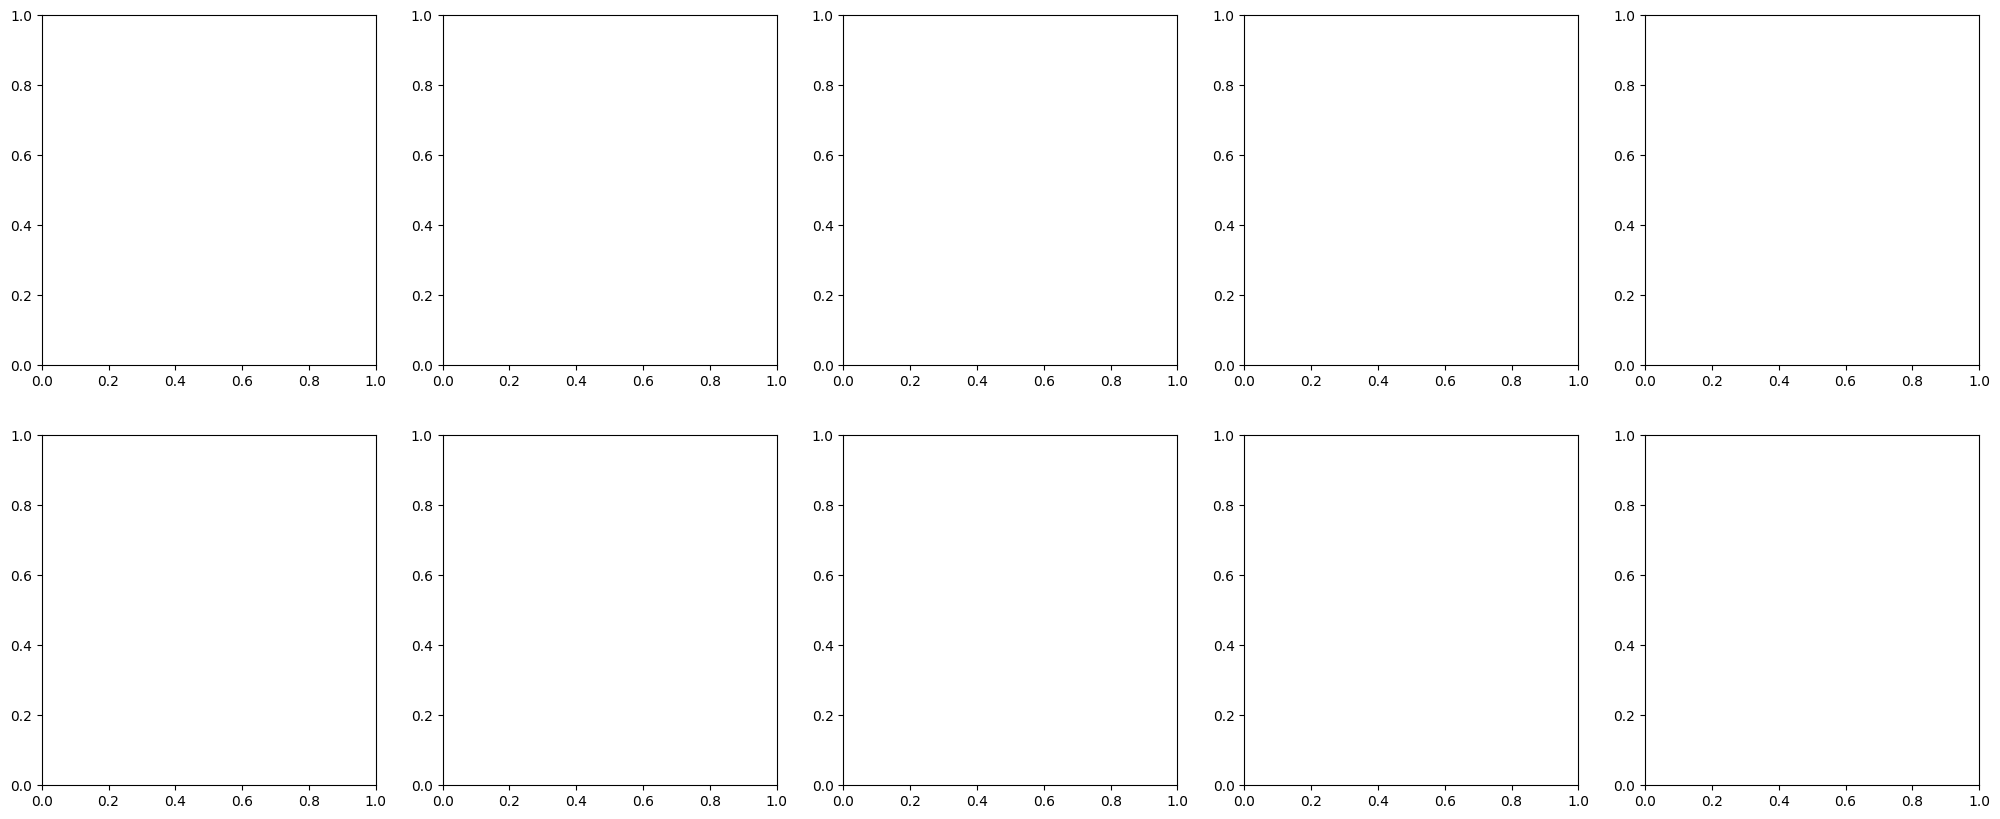

In [6]:
def visualize_context_mla(database):
    b = 8
    n_list = [2, 4, 8, 16, 32]
    s_list = [16, 32, 64, 128, 256, 512, 1024, 2048, 4096, 8192, 16384, 32768, 524288]

    color_list = [
        "red",
        "blue",
        "green",
        "orange",
        "purple",
        "brown",
        "pink",
        "gray",
        "olive",
        "cyan",
    ]
    fig, ax = plt.subplots(2, len(n_list), figsize=(5 * len(n_list), 5 * 2))
    color_id = 0
    for i, n_q in enumerate(n_list):
        for quant_mode in database._context_mla_data.keys():
            for kvcache_quant_mode in database._context_mla_data[quant_mode].keys():
                sol_math_list = []
                sol_mem_list = []
                for s in s_list:
                    sol_time, sol_math, sol_mem = database.query_context_mla(
                        b,
                        s,
                        n_q,
                        kvcache_quant_mode=kvcache_quant_mode,
                        fmha_quant_mode=quant_mode,
                        sol_mode=SOLMode.SOL_FULL,
                    )
                    db_time = database.query_context_mla(
                        b,
                        s,
                        n_q,
                        kvcache_quant_mode=kvcache_quant_mode,
                        fmha_quant_mode=quant_mode,
                        sol_mode=SOLMode.NON_SOL,
                    )
                    percentage_of_math = sol_math / db_time
                    percentage_of_mem = sol_mem / db_time
                    sol_math_list.append(percentage_of_math)
                    sol_mem_list.append(percentage_of_mem)
                ax[0, i].plot(
                    s_list,
                    sol_math_list,
                    color=color_list[color_id % len(color_list)],
                    label=f"{quant_mode}_{kvcache_quant_mode} math",
                )
                ax[1, i].plot(
                    s_list,
                    sol_mem_list,
                    color=color_list[color_id % len(color_list)],
                    linestyle="--",
                    label=f"{quant_mode}_{kvcache_quant_mode} mem",
                )
                color_id += 1
        ax[0, i].set_title(f"b={b} n_q={n_q}")
        ax[0, i].set_xlabel("s")
        ax[0, i].set_ylabel("math sol %")
        ax[0, i].set_ylim(0, 1)
        ax[0, i].legend()
        ax[1, i].set_xlabel("s")
        ax[1, i].set_ylabel("mem sol %")
        ax[1, i].set_ylim(0, 1)
        ax[1, i].legend()
    plt.show()


visualize_context_mla(database)

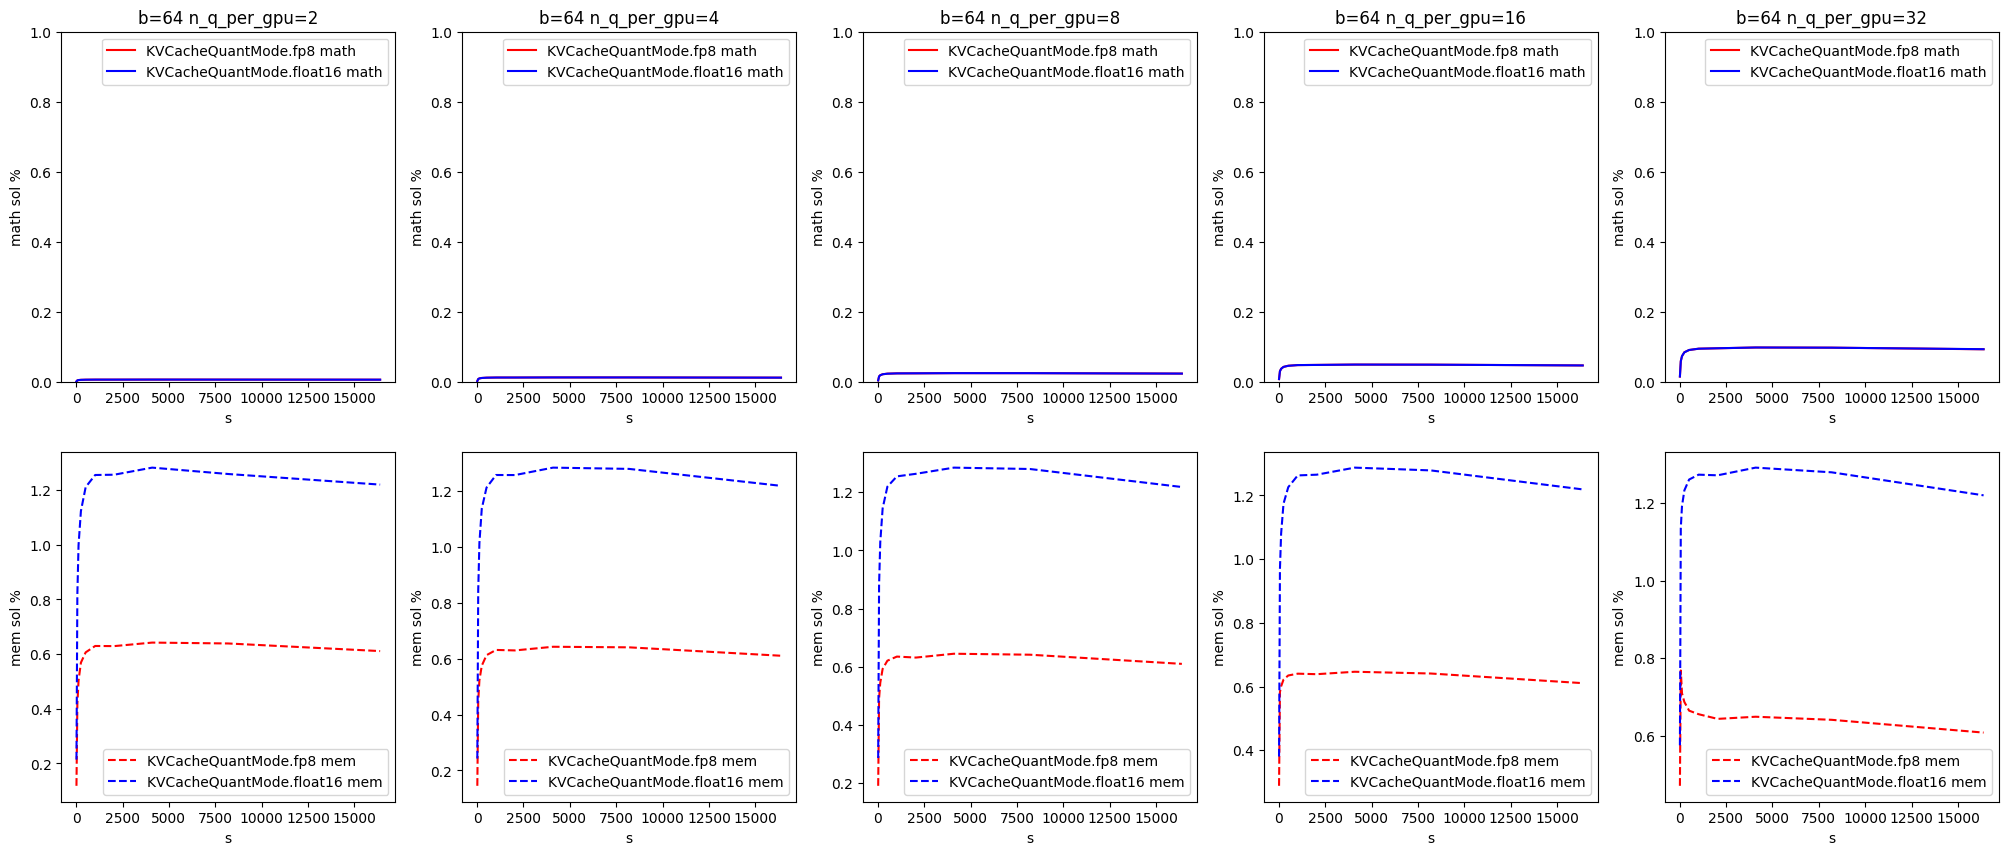

In [7]:
def visualize_generation_mla(database):
    b = 64
    n_list = [2, 4, 8, 16, 32]
    s_list = [16, 32, 64, 128, 256, 512, 1024, 2048, 4096, 8192, 16384]

    color_list = [
        "red",
        "blue",
        "green",
        "orange",
        "purple",
        "brown",
        "pink",
        "gray",
        "olive",
        "cyan",
    ]
    fig, ax = plt.subplots(2, len(n_list), figsize=(5 * len(n_list), 5 * 2))
    for i, n_q_per_gpu in enumerate(n_list):
        for color_id, kvcache_quant_mode in enumerate(database._generation_mla_data.keys()):
            sol_math_list = []
            sol_mem_list = []
            for s in s_list:
                sol_time, sol_math, sol_mem = database.query_generation_mla(
                    b=b,
                    s=s,
                    num_heads=n_q_per_gpu,
                    kvcache_quant_mode=kvcache_quant_mode,
                    sol_mode=SOLMode.SOL_FULL,
                )
                db_time = database.query_generation_mla(
                    b=b,
                    s=s,
                    num_heads=n_q_per_gpu,
                    kvcache_quant_mode=kvcache_quant_mode,
                    sol_mode=SOLMode.NON_SOL,
                )
                percentage_of_math = sol_math / db_time
                percentage_of_mem = sol_mem / db_time
                sol_math_list.append(percentage_of_math)
                sol_mem_list.append(percentage_of_mem)
            ax[0, i].plot(
                s_list,
                sol_math_list,
                color=color_list[color_id],
                label=f"{kvcache_quant_mode} math",
            )
            ax[1, i].plot(
                s_list,
                sol_mem_list,
                color=color_list[color_id],
                linestyle="--",
                label=f"{kvcache_quant_mode} mem",
            )
        ax[0, i].set_title(f"b={b} n_q_per_gpu={n_q_per_gpu}")
        ax[0, i].set_xlabel("s")
        ax[0, i].set_ylabel("math sol %")
        ax[0, i].set_ylim(0, 1)
        ax[0, i].legend()
        ax[1, i].set_xlabel("s")
        ax[1, i].set_ylabel("mem sol %")
        # ax[1,i].set_ylim(0,1)
        ax[1, i].legend()
    plt.show()


visualize_generation_mla(database)
# visualize_generation_attention(database_fixed)

ValueError: x is greater than the largest value in the list. x=65535, sorted_values=[2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048, 4096, 8192, 16384, 32768]

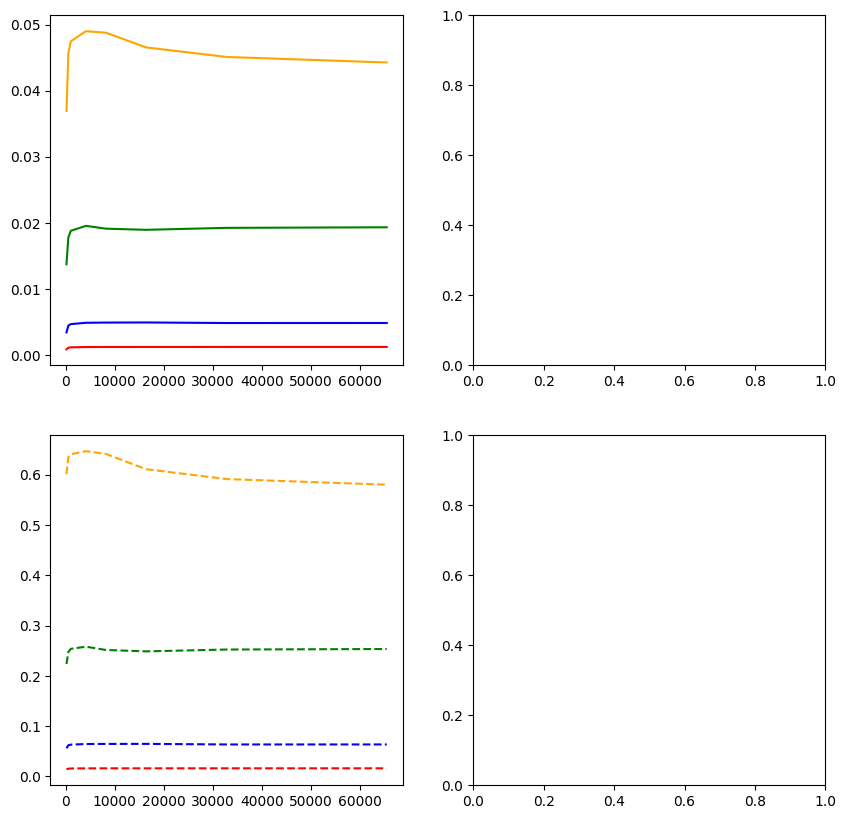

In [8]:
def visualize_generation_mla_b(database):
    b_list = [1, 4, 16, 64, 256, 1024]
    num_q = 16
    s_list = [128, 512, 1024, 4096, 8192, 16384, 32768, 65535]

    color_list = [
        "red",
        "blue",
        "green",
        "orange",
        "purple",
        "brown",
        "pink",
        "gray",
        "olive",
        "cyan",
    ]
    fig, ax = plt.subplots(
        2,
        len(database._generation_mla_data.keys()),
        figsize=(5 * len(database._generation_mla_data.keys()), 5 * 2),
    )
    for i, kvcache_quant_mode in enumerate(database._generation_mla_data.keys()):
        for color_id, b in enumerate(b_list):
            sol_math_list = []
            sol_mem_list = []
            for s in s_list:
                sol_time, sol_math, sol_mem = database.query_generation_mla(
                    b=b,
                    s=s,
                    num_heads=num_q,
                    kvcache_quant_mode=kvcache_quant_mode,
                    sol_mode=SOLMode.SOL_FULL,
                )
                db_time = database.query_generation_mla(
                    b=b,
                    s=s,
                    num_heads=num_q,
                    kvcache_quant_mode=kvcache_quant_mode,
                    sol_mode=SOLMode.NON_SOL,
                )
                percentage_of_math = sol_math / db_time
                percentage_of_mem = sol_mem / db_time
                sol_math_list.append(percentage_of_math)
                sol_mem_list.append(percentage_of_mem)
            ax[0, i].plot(s_list, sol_math_list, color=color_list[color_id], label=f"b{b} math")
            ax[1, i].plot(
                s_list, sol_mem_list, color=color_list[color_id], linestyle="--", label=f"b{b} mem"
            )
        ax[0, i].set_title(f"kvcache={kvcache_quant_mode} n_q_per_gpu={num_q}")
        ax[0, i].set_xlabel("s")
        ax[0, i].set_ylabel("math sol %")
        ax[0, i].set_ylim(0, 1)
        ax[0, i].legend()
        ax[1, i].set_xlabel("s")
        ax[1, i].set_ylabel("mem sol %")
        # ax[1,i].set_ylim(0,1)
        ax[1, i].legend()
    plt.show()


visualize_generation_mla_b(database)

AssertionError: values is None or len(values) < 2

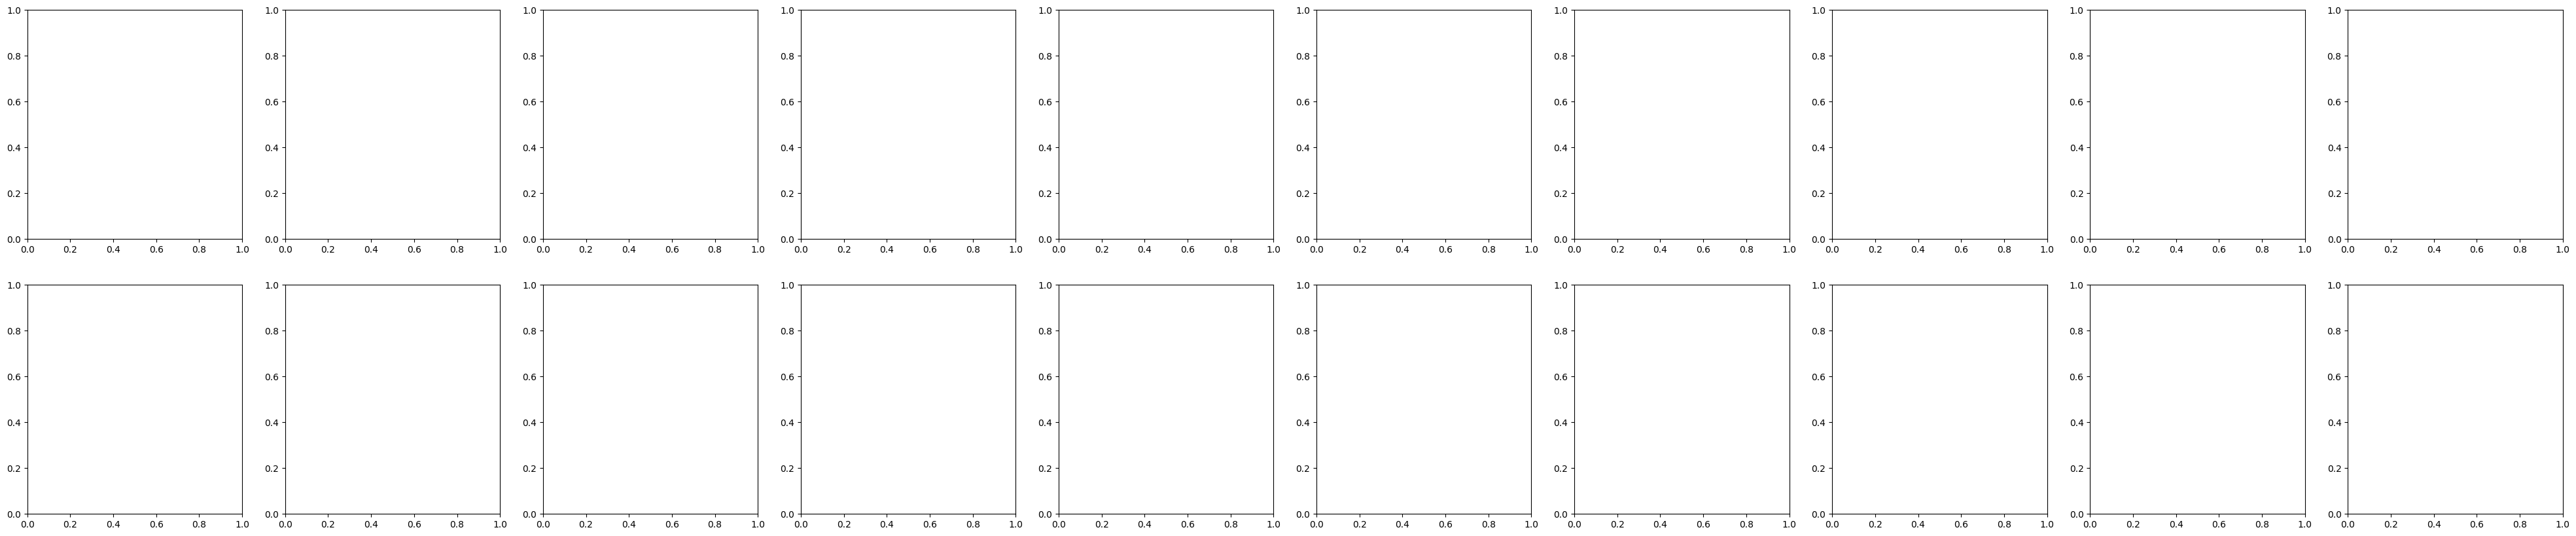

In [9]:
def visualize_moe(database):
    topk = 8
    num_experts = 256
    hidden_size = 7168
    inter_size = 2048
    workload_distribution = "power_law_1.01"
    tp_list = [1, 2, 4, 8]
    ep_list = [1, 2, 4, 8]
    tp_ep_list = []
    for tp in tp_list:
        for ep in ep_list:
            if tp * ep >= 4 and tp * ep <= 16:
                tp_ep_list.append([tp, ep])
    m_list = [1, 16, 32, 64, 128, 256, 512, 1024, 2048, 4096, 8192, 16384, 32768, 65536, 65536 * 4]
    color_list = [
        "red",
        "blue",
        "green",
        "orange",
        "purple",
        "brown",
        "pink",
        "gray",
        "olive",
        "cyan",
    ]
    fig, ax = plt.subplots(2, len(tp_ep_list), figsize=(5 * len(tp_ep_list), 5 * 2))
    for i, (tp, ep) in enumerate(tp_ep_list):
        for color_id, quant_mode in enumerate(database._moe_data.keys()):
            sol_math_list = []
            sol_mem_list = []
            for m in m_list:
                sol_time, sol_math, sol_mem = database.query_moe(
                    num_tokens=m,
                    hidden_size=hidden_size,
                    inter_size=inter_size,
                    topk=topk,
                    num_experts=num_experts,
                    moe_tp_size=tp,
                    moe_ep_size=ep,
                    quant_mode=quant_mode,
                    workload_distribution=workload_distribution,
                    sol_mode=SOLMode.SOL_FULL,
                )
                db_time = database.query_moe(
                    num_tokens=m,
                    hidden_size=hidden_size,
                    inter_size=inter_size,
                    topk=topk,
                    num_experts=num_experts,
                    moe_tp_size=tp,
                    moe_ep_size=ep,
                    quant_mode=quant_mode,
                    workload_distribution=workload_distribution,
                    sol_mode=SOLMode.NON_SOL,
                )
                percentage_of_math = sol_math / db_time
                percentage_of_mem = sol_mem / db_time
                sol_math_list.append(percentage_of_math)
                sol_mem_list.append(percentage_of_mem)
            ax[0, i].plot(
                m_list, sol_math_list, color=color_list[color_id], label=f"{quant_mode} math"
            )
            ax[1, i].plot(
                m_list,
                sol_mem_list,
                color=color_list[color_id],
                linestyle="--",
                label=f"{quant_mode} mem",
            )
        ax[0, i].set_title(f"topk={topk} e={num_experts} tp={tp} ep={ep}")
        ax[0, i].set_xlabel("s")
        ax[0, i].set_ylabel("math sol %")
        # ax[0,i].set_ylim(0,1)
        ax[0, i].legend()
        ax[1, i].set_xlabel("s")
        ax[1, i].set_ylabel("mem sol %")
        # ax[1,i].set_ylim(0,1)
        ax[1, i].legend()
    plt.show()


visualize_moe(database)

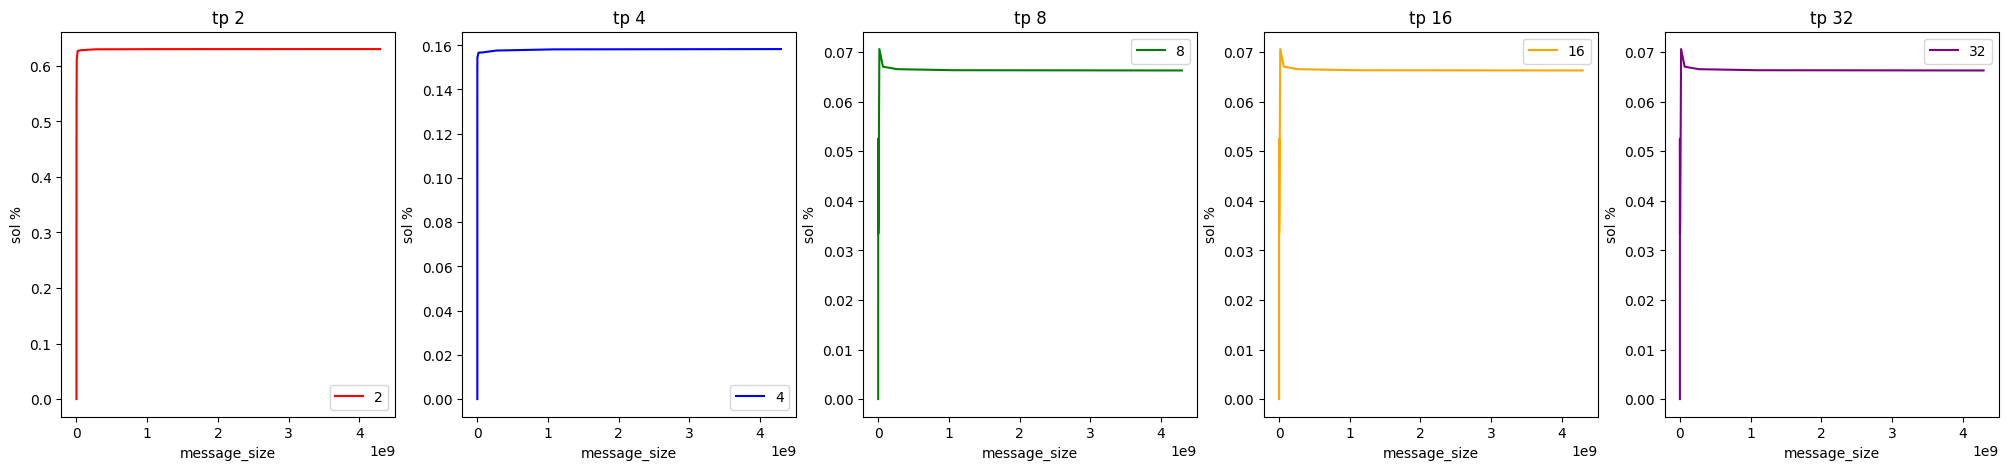

In [6]:
def visualize_allreduce(database):
    quant_mode = common.CommQuantMode.half
    m_list = [
        2**0,
        2**1,
        2**2,
        2**4,
        2**6,
        2**8,
        2**10,
        2**12,
        2**14,
        2**16,
        2**18,
        2**20,
        2**22,
        2**24,
        2**26,
        2**28,
        2**30,
        2**32,
    ]
    color_list = [
        "red",
        "blue",
        "green",
        "orange",
        "purple",
        "brown",
        "pink",
        "gray",
        "olive",
        "cyan",
    ]
    if system == "gb200_sxm":
        tp_list = [2, 4]
    else:
        tp_list = [2, 4, 8, 16, 32]
    fig, ax = plt.subplots(1, len(tp_list), figsize=(5 * len(tp_list), 5 * 1))
    for i, tp_size in enumerate(tp_list):
        sol_list = []
        for m in m_list:
            sol_time, sol_math, sol_mem = database.query_custom_allreduce(
                quant_mode, tp_size, m, sol_mode=SOLMode.SOL_FULL
            )
            db_time = database.query_custom_allreduce(quant_mode, tp_size, m, sol_mode=SOLMode.NON_SOL)
            percentage_of_sol = sol_time / db_time
            sol_list.append(percentage_of_sol)
        ax[i].plot(m_list, sol_list, color=color_list[i], label=f"{tp_size}")
        ax[i].set_title(f"tp {tp_size}")
        # ax[i].set_xscale('log', base=2)
        ax[i].set_xlabel("message_size")
        ax[i].set_ylabel("sol %")
        # ax[i].set_ylim(0,1)
        ax[i].legend()
    plt.show()


visualize_allreduce(database)

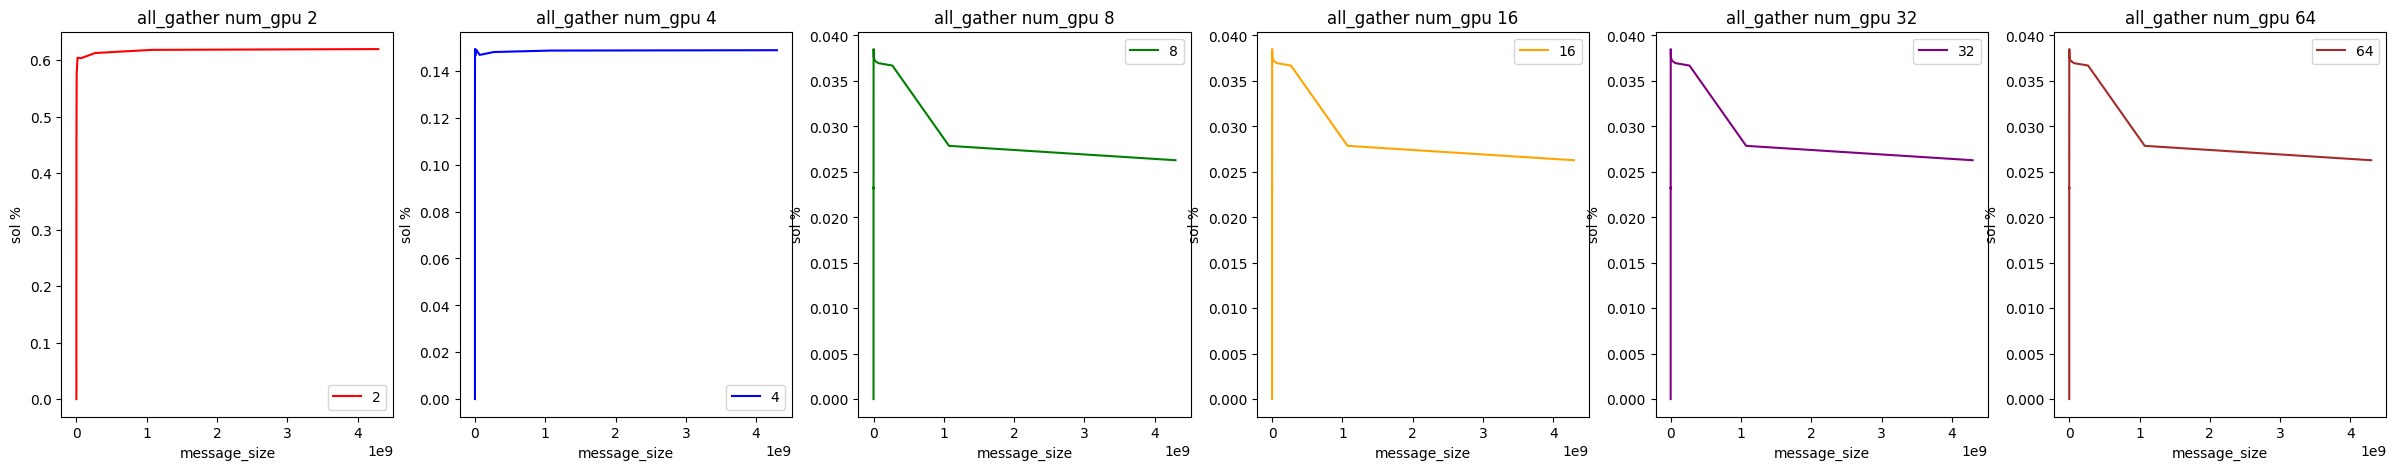

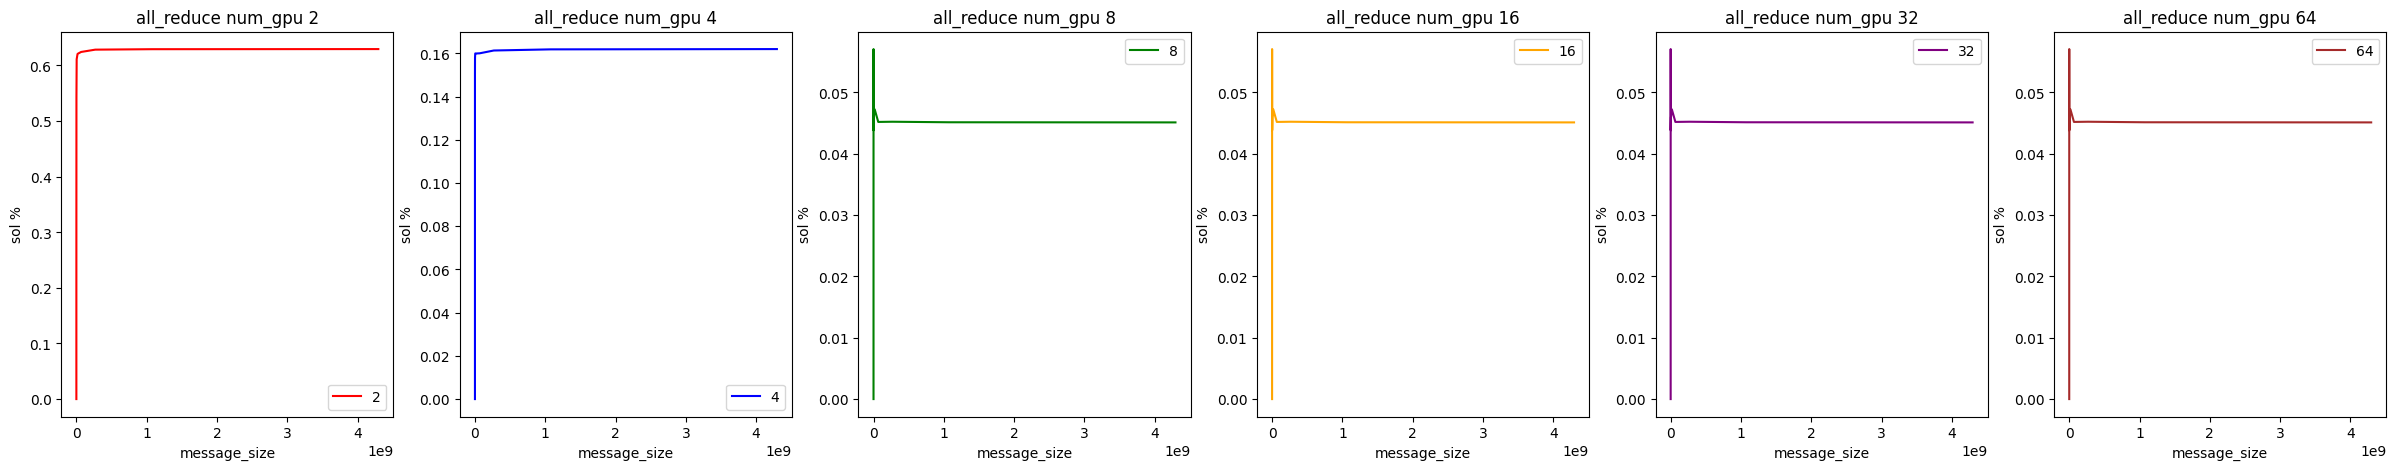

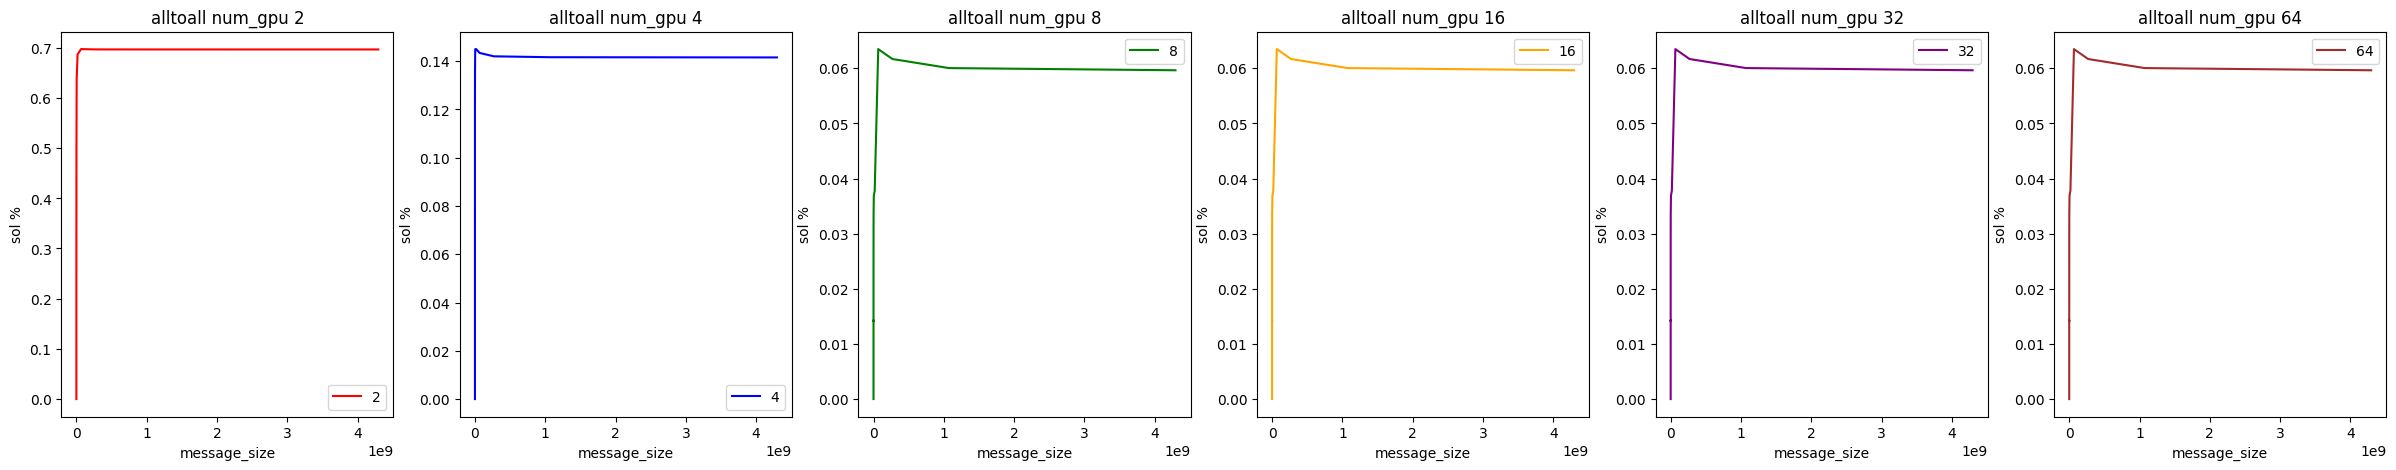

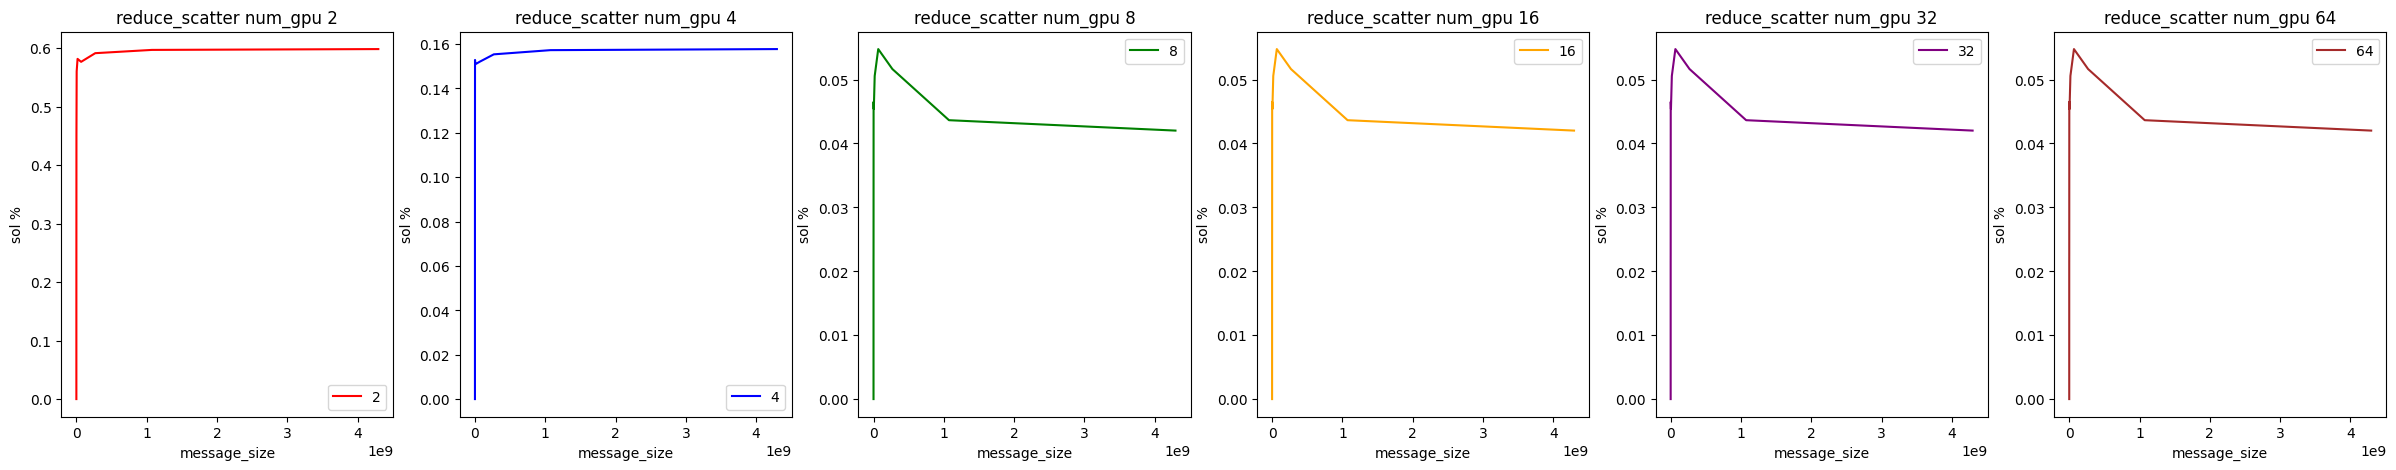

In [10]:
def visualize_nccl(database, operation="all_gather"):
    quant_mode = common.CommQuantMode.half
    m_list = [
        2**0,
        2**1,
        2**2,
        2**4,
        2**6,
        2**8,
        2**10,
        2**12,
        2**14,
        2**16,
        2**18,
        2**20,
        2**22,
        2**24,
        2**26,
        2**28,
        2**30,
        2**32,
    ]
    color_list = [
        "red",
        "blue",
        "green",
        "orange",
        "purple",
        "brown",
        "pink",
        "gray",
        "olive",
        "cyan",
    ]
    num_gpu_list = [2, 4, 8, 16, 32, 64]
    fig, ax = plt.subplots(1, len(num_gpu_list), figsize=(5 * len(num_gpu_list), 5 * 1))
    for i, num_gpu in enumerate(num_gpu_list):
        sol_list = []
        for m in m_list:
            sol_time, sol_math, sol_mem = database.query_nccl(
                quant_mode, num_gpu, operation, m, sol_mode=SOLMode.SOL_FULL
            )
            db_time = database.query_nccl(
                quant_mode, num_gpu, operation, m, sol_mode=SOLMode.NON_SOL
            )
            percentage_of_sol = sol_time / db_time
            sol_list.append(percentage_of_sol)
        ax[i].plot(m_list, sol_list, color=color_list[i], label=f"{num_gpu}")
        ax[i].set_title(f"{operation} num_gpu {num_gpu}")
        # ax[i].set_xscale('log', base=2)
        ax[i].set_xlabel("message_size")
        ax[i].set_ylabel("sol %")
        # ax[i].set_ylim(0,1)
        ax[i].legend()
    plt.show()


op_list = ["all_gather", "all_reduce", "alltoall", "reduce_scatter"]
for op in op_list:
    visualize_nccl(database, operation=op)